# Advanced Lane Lines


1. The goals / steps of this project are the following:
2. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
3. Apply a distortion correction to raw images.
4. Use color transforms, gradients, etc., to create a thresholded binary image.
5. Apply a perspective transform to rectify binary image ("birds-eye view").
6. Detect lane pixels and fit to find the lane boundary.
7. Determine the curvature of the lane and vehicle position with respect to center.
8. Warp the detected lane boundaries back onto the original image.
9. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import math
%matplotlib inline

## Camera Calibration

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and object_points will be appended with a copy of it every time I successfully detect all chessboard corners in a test image and img_points will be appended with the (x, y) pixel position of each of the corners in the image. The code tries to find a chessboard pattern of 6 rows and 9 columns and if it fails, try to search for a chessboard pattern of 5 rows and 9 columns. I then used the output obj_points and img_points to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function.


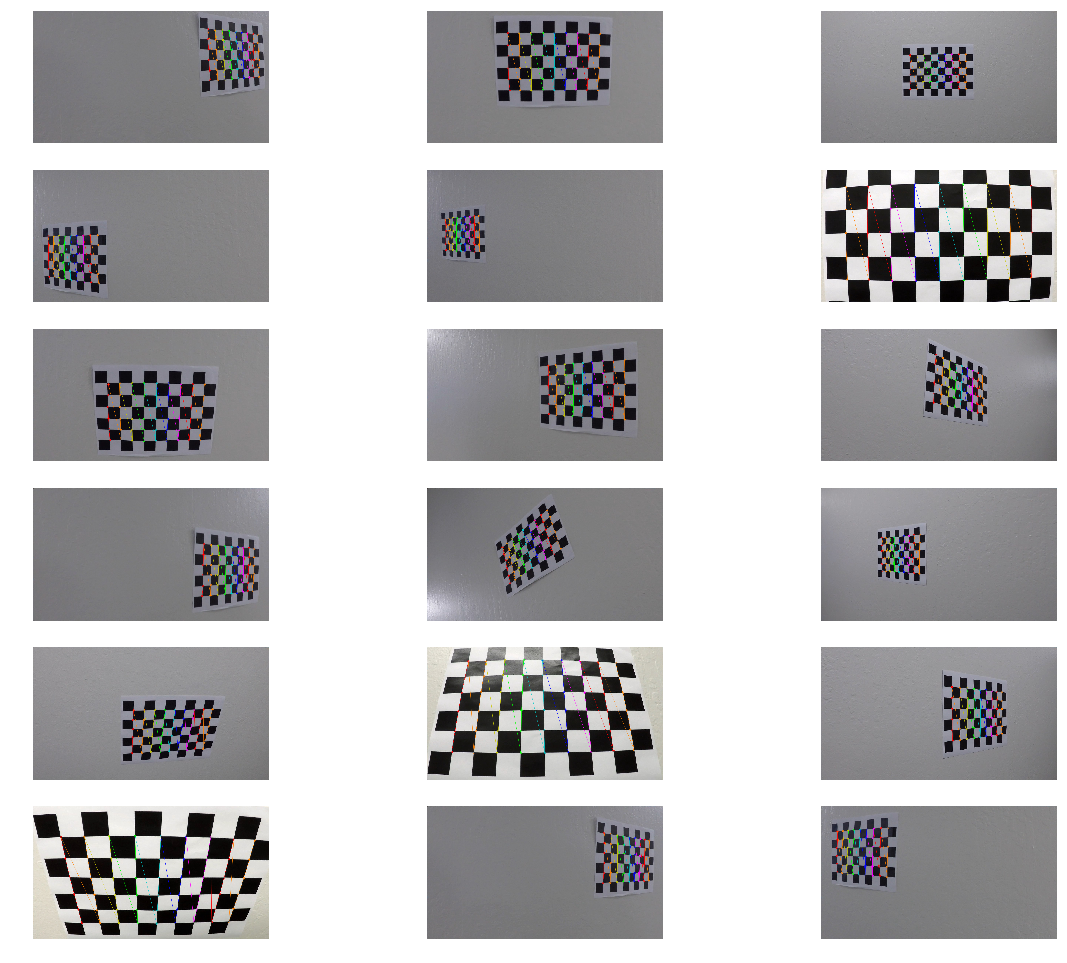

In [2]:
def get_calibration_matrix(path):
    """Returns camera calibration matrix using
    chessboard images in given glob path
    assuming 6x9 or 5x9 chess corners
    """
    object_points = []  # 3d point in real world space
    img_points = []  # 2d points in image plane.

    images = glob.glob(path)
    total_image_count = len(images)

    image_count = 1
    fig = plt.figure()
    for filename in images:
        img = cv2.imread(filename)
        nx, ny = 6, 9
        retval, corners = cv2.findChessboardCorners(img, (nx, ny))
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0: nx, 0: ny].T.reshape(-1, 2)
        
        if not retval:
            nx, ny = 5, 9 # Trying with 5 rows
            objp = np.zeros((nx * ny, 3), np.float32)
            objp[:, :2] = np.mgrid[0: nx, 0: ny].T.reshape(-1, 2)
            retval, corners = cv2.findChessboardCorners(img, (nx, ny))

        if retval:
            object_points.append(objp)
            img_points.append(corners)

            ax = fig.add_subplot(math.ceil(total_image_count / 3), 3, image_count)
            chessboard_with_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, retval)
            chessboard_with_corners = cv2.cvtColor(chessboard_with_corners, cv2.COLOR_BGR2RGB)
            ax.imshow(chessboard_with_corners)
            scipy.misc.imsave('output_images/chessboard_with_corners.jpg', chessboard_with_corners)

            ax.axis('off')
            image_count += 1
    return cv2.calibrateCamera(object_points, img_points, img.shape[0:2], None, None), fig



(ret, cameraMat, distCoeffs, rvecs, tvecs), fig = get_calibration_matrix(os.path.join('camera_cal','*.jpg'))
fig.set_size_inches(20,20)


([], <a list of 0 Text yticklabel objects>)

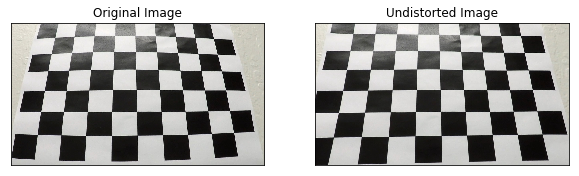

In [3]:
test_image = plt.imread(os.path.join('camera_cal', 'calibration3.jpg'))
undistorted_img = cv2.undistort(test_image, cameraMat, distCoeffs)


plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

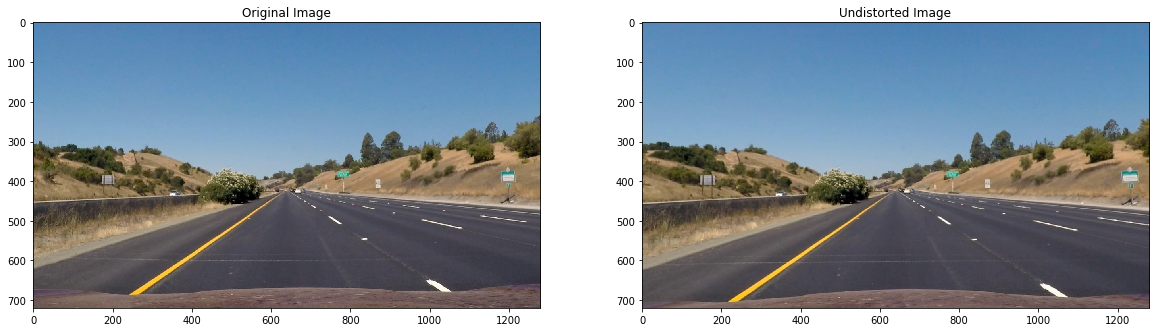

In [4]:
test_image = plt.imread(os.path.join('test_images', 'straight_lines1.jpg'))
undistorted_img = cv2.undistort(test_image, cameraMat, distCoeffs)

scipy.misc.imsave('output_images/distorted_undistorted.jpg', undistorted_img)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')


plt.subplot(122)
plt.imshow(undistorted_img)
plt.savefig("undistorted_img.jpg")
plt.title('Undistorted Image')


[[  1.16022198e+03   0.00000000e+00   6.68287520e+02]
 [  0.00000000e+00   1.15738376e+03   3.89456209e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[-0.25129424  0.028224   -0.00053583  0.00037272 -0.08995033]]


<function matplotlib.pyplot.show>

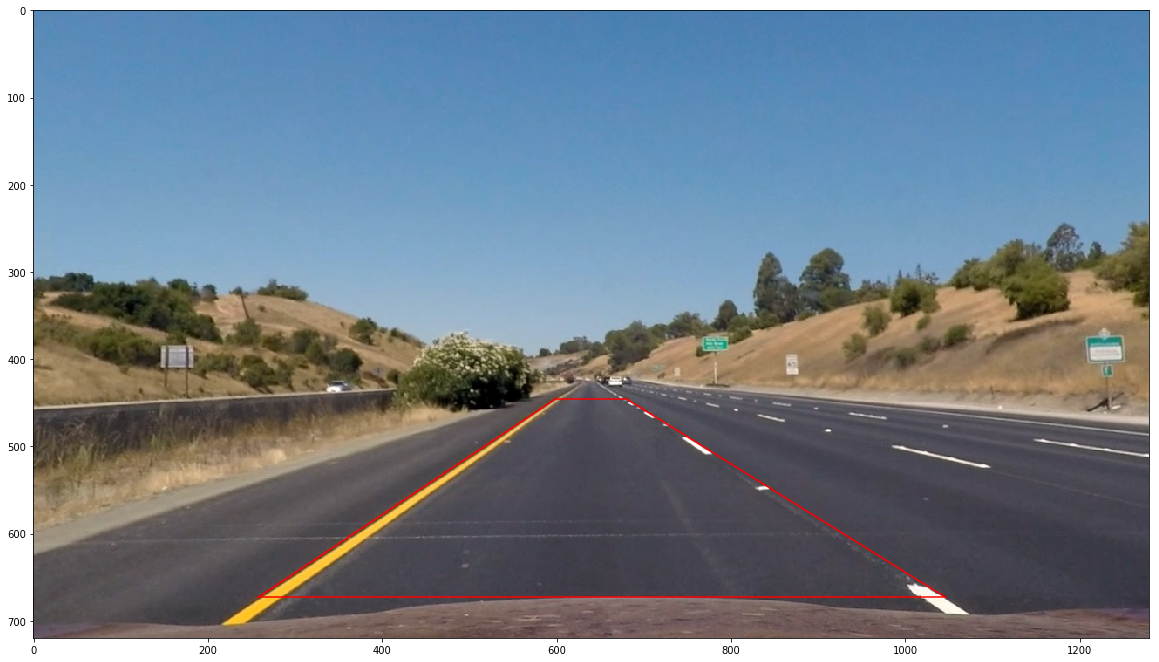

In [5]:
import matplotlib.patches as patches

from pathlib import Path
fig = plt.figure(figsize=(20,40))


print(cameraMat)
print(distCoeffs)
undistorted_img = cv2.undistort(plt.imread("test_images/straight_lines1.jpg"), cameraMat, distCoeffs)

oldpoints='''
plt.plot([588, 691], [446, 446], 'k-', color='#FF0000')
plt.plot([153, 1126], [673, 673], 'k-', color='#FF0000')

plt.plot([153, 588], [673, 446], 'k-', color='#FF0000')
plt.plot([1126, 691], [673, 446], 'k-', color='#FF0000')
'''
 
plt.plot([598, 681], [446, 446], 'k-', color='#FF0000')
plt.plot([258, 1046], [673, 673], 'k-', color='#FF0000')

plt.plot([258, 598], [673, 446], 'k-', color='#FF0000')
plt.plot([1046, 681], [673, 446], 'k-', color='#FF0000')    



plt.imshow(undistorted_img)

    
plt.show



   

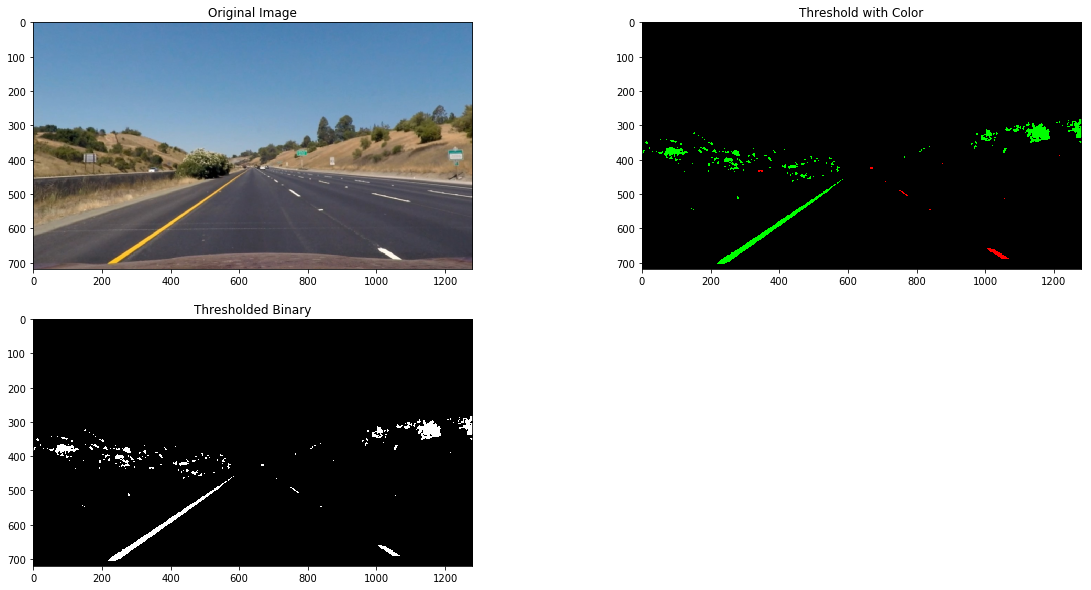

In [6]:
def mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def threshold(img, color=False, mag_dir_thresh=False):
    """Threshhold image on saturation channel and 
    using magnitude gradient"""
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    # Dir Mag Threshold
    if mag_dir_thresh:
        dir_mask = dir_threshold(img)
        mag_mask = mag_thresh(img)
        combined_binary[((dir_mask == 1) & (mag_mask == 1))] = 255
        
    if color:
        return np.dstack((white_mask, yellow_mask, combined_binary))
    
    else:
        combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
        combined_binary[(combined_binary == 255)] = 1
        return combined_binary





# undistorted_img = cv2.undistort(plt.imread("test_images/test4.jpg"), cameraMat, distCoeffs)
undistorted_img = cv2.undistort(plt.imread("test_images/straight_lines1.jpg"), cameraMat, distCoeffs)

kernel = np.ones((11,11),np.uint8)

plt.figure(figsize=(20,10))


kernel_size = 5
test_image = cv2.GaussianBlur(undistorted_img, (kernel_size, kernel_size), 0)


plt.subplot(2,2,1)
plt.imshow(test_image)
plt.title('Original Image')

plt.subplot(2,2,2)
thresholded = threshold(test_image, color=True)
plt.imshow(thresholded)
plt.title('Threshold with Color')

plt.subplot(2,2,3)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')


SRC POINTS
[[  598.   446.]
 [  681.   446.]
 [ 1046.   673.]
 [  258.   673.]]
DST POINTS
[[  200.     0.]
 [ 1080.     0.]
 [ 1080.   720.]
 [  200.   720.]]


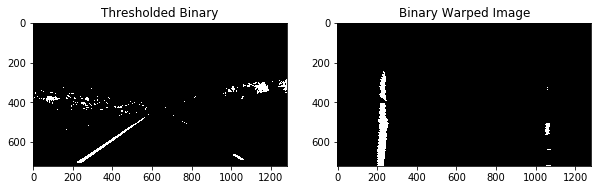

In [7]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
offset = 200

oldsrc='''
src = np.float32([
    [  588,   446 ],
    [  691,   446 ],
    [ 1126,   673 ],
    [  153 ,   673 ]])
'''

src = np.float32([
    [  598,   446 ],
    [  681,   446 ],
    [ 1046,   673 ],
    [  258 ,   673 ]])
print("SRC POINTS")
print(src)
print("DST POINTS")

dst = np.float32([[offset, 0], [(img_size[0] - offset), 0], [(img_size[0] - offset), img_size[1]], [offset, img_size[1]]])
print(dst)



M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(b_thresholded,M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')





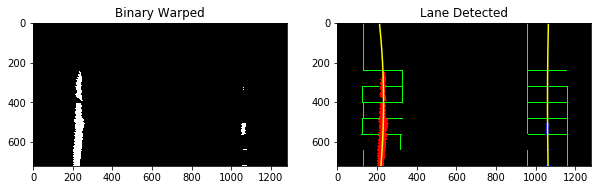

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
# 

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)



# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')


Radius of curvature in pixel values:
1586.95659316 1534.58510907
---
Radius of curvature in meters (approximately):
655.113033175 m 632.96446897 m
---
Average of left and right curvature: 644.038751073


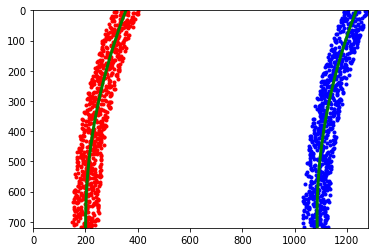

In [9]:

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([1080 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Radius of curvature in pixel values:")

print(left_curverad, right_curverad)


# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/880 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("---")
print("Radius of curvature in meters (approximately):")
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m
print("---")
curvature=(left_curverad+right_curverad)/2
print("Average of left and right curvature:",curvature)
oldsubmission='''

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

y_eval = 720
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

print(len(ploty))
print(len(leftx))
print (ym_per_pix)
print(xm_per_pix)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
'''

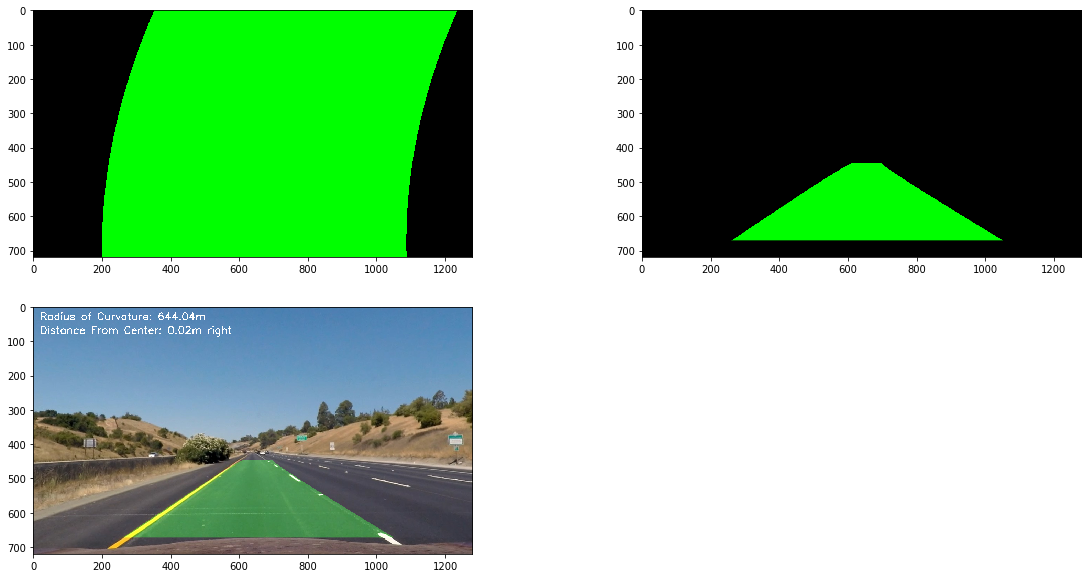

In [10]:
plt.figure(figsize=(20,10))

y_eval = 720
midx = 640

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

plt.subplot(2,2,1)
plt.imshow(color_warp)

newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
plt.subplot(2,2,2)

plt.imshow(newwarp)

# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.subplot(2,2,3)

plt.imshow(result)
scipy.misc.imsave('output_images/result.jpg', result)


In [11]:
from pipeline import Pipeline

from line import Line
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()
Pipeline.set_values(line, M, Minv, cameraMat, distCoeffs)

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")



white_clip = clip1.fl_image(Pipeline.pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:08<00:00, 18.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 41s, sys: 1.67 s, total: 1min 42s
Wall time: 1min 9s
